In [3]:
import os
import tensorflow as tf
from sklearn.utils import shuffle

In [4]:
x = [1,2,3,4,5]
y = ['a','b','c','d','e']
random_seed =1000
print(shuffle(x,random_state=random_seed))
print(shuffle(y,random_state=random_seed))

[3, 2, 1, 5, 4]
['c', 'b', 'a', 'e', 'd']


In [20]:
import numpy as np
import cv2
import os
root_path = os.getcwd()

class CustomDataGen(tf.keras.utils.Sequence):
    def __init__(self, X:np.array, Y: np.array, batch_size : int = 8 ,input_size : int  = 128, shuffel : bool =True, data_aug: bool = True):
        self.X = X
        self.Y = Y
        self.batch_size = batch_size
        self.IMG_SIZe = input_size
        self.shuffel = shuffel
        self.data_aug = data_aug

    def __len__(self):
        return int(len(self.X)/self.batch_size) 
    
    
    def __img_preprocess(self, image_path):
        img = cv2.imread(image_path)
        if img is None:
            return None
        
        image = tf.cast(img,tf.float32)
        image = tf.image.resize(image, [self.IMG_SIZe, self.IMG_SIZe])
        image = (image/255.0)
        
        if self.data_aug:
            augmented_image = self.data_augmentation(image)
            return augmented_image

        else:
            return image
        

    def data_augmentation(self,image):
        data_augmentation = tf.keras.Sequentail(
            [
                tf.keras.layers.RandomFlip(mode="HORIZONTAL_AND_VERTICAL"),
                tf.keras.layers.RadomRotation(0.2)
            ]
        )
        augmented_image = data_augmentation(image)
        return augmented_image
        

    def __get_data(self,x_batches, y_batches):
        X_batches = []
        Y_batches = []
        for x,y in zip(x_batches, y_batches):
            preprocessed_img = self.__img_preprocess(x)
            if preprocessed_img is None:
                continue
            X_batches.append(preprocessed_img)
            Y_batches.append(y)
            
        return np.array(X_batches),np.array(Y_batches)
    

    
    def __getitem__(self,idx):
        if self.shuffel:
            seed = np.random.randint(1,100)
        else:
            seed = 0

        self.X = shuffle(self.X, random_state=seed)
        self.Y = shuffle(self.Y, random_state=seed)

        batch_x = self.X[idx * self.batch_size : (idx+1)*self.batch_size]
        btach_y = self.Y[idx * self.batch_size : (idx+1)*self.batch_size]

        cur_X,cur_Y = self.__get_data(batch_x,btach_y)
        return cur_X,cur_Y


    def on_epoch_end(self):
        print("on_epoch_end")
        seed = 0
        self.X = shuffle(self.X, random_state=seed)
        self.Y = shuffle(self.Y, random_state=seed)



In [21]:
label_encode = {
    'cats' : [1,0],
    'dogs' : [0,1]
}

def load_dataset(dataset_path : str):
    x_test,y_test = [],[]
    for cur_class in os.listdir(dataset_path):
        temp_path = dataset_path+"/"+cur_class
        for filename in os.listdir(temp_path):
            img_path = temp_path+"/"+filename
            encoded_label = label_encode[cur_class]
            x_test.append(img_path)
            y_test.append(encoded_label)

    x_test = np.array(x_test)
    y_test = np.array(y_test)

    return x_test,y_test
    
train_path = os.getcwd()+"/cats_and_dogs_filtered/train"
x_trian,y_train = load_dataset(train_path)
print("x_trian : ",x_trian.shape)
print("y_train : ",y_train.shape)



test_path = os.getcwd()+"/cats_and_dogs_filtered/test"
x_test,y_test = load_dataset(test_path)
print("x_test : ",x_test.shape)
print("y_test : ",y_test.shape)

x_trian :  (2752,)
y_train :  (2752, 2)
x_test :  (248,)
y_test :  (248, 2)


In [29]:
batch_size = 8
input_size = 128
input_shape = (128,128,3)


test_gen = CustomDataGen(X=x_test,Y=y_test,batch_size=batch_size,input_size=input_size,shuffel=True,data_aug=False)
train_gen = CustomDataGen(X=x_trian,Y=y_train,batch_size=batch_size,input_size=input_size,shuffel=True,data_aug=False)




[0 1]
(128, 128, 3)


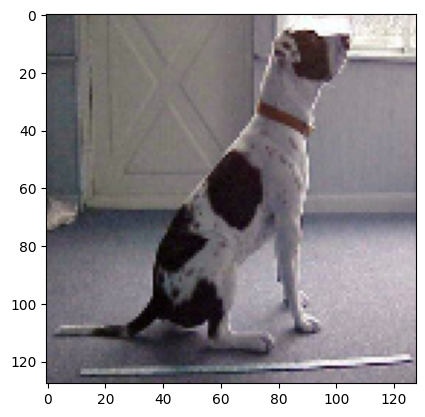

In [30]:
import matplotlib.pyplot as plt

test_label = None
test_img = None
for img,label in test_gen:
    test_img = img
    test_label = label
    break

print(test_label[0])
print(test_img[0].shape)
plt.imshow(test_img[0])

In [31]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Dense,Flatten,MaxPooling2D

model = Sequential([
    Conv2D(32,(3,3),activation="relu",input_shape=input_shape),
    Conv2D(32,(3,3),activation="relu"),
    
    MaxPooling2D((2,2)),
    Conv2D(64,(3,3),activation="relu"),
    Conv2D(64,(3,3),activation="relu"),
    
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(512,activation="relu"),
    Dense(2,activation='softmax')
    
])



/opt/anaconda3/envs/dev_env/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [32]:
from tensorflow.keras.optimizers import Adam
model.compile(loss='categorical_crossentropy',
              optimizer = Adam(0.001),
              metrics = ['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 124, 124, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 58, 58, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 53824)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    27,558,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,624,994 (105.38 MB)

 Trainable params: 27,624,994 (105.38 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
history = model.fit(train_gen,validation_data=test_gen,epochs=20,verbose=1)

Epoch 1/20


2025-01-18 10:59:49.930353: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
/opt/anaconda3/envs/dev_env/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.5282 - loss: 0.7253on_epoch_end
on_epoch_end
344/344 ━━━━━━━━━━━━━━━━━━━━ 34s 94ms/step - accuracy: 0.5282 - loss: 0.7253 - val_accuracy: 0.5323 - val_loss: 0.6899
Epoch 2/20
344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.5743 - loss: 0.6787on_epoch_end
on_epoch_end
344/344 ━━━━━━━━━━━━━━━━━━━━ 31s 90ms/step - accuracy: 0.5744 - loss: 0.6787 - val_accuracy: 0.5282 - val_loss: 0.6878
Epoch 3/20
344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.6856 - loss: 0.6041on_epoch_end
on_epoch_end
344/344 ━━━━━━━━━━━━━━━━━━━━ 34s 98ms/step - accuracy: 0.6857 - loss: 0.6041 - val_accuracy: 0.5403 - val_loss: 0.8472
Epoch 4/20
344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.8032 - loss: 0.4426on_epoch_end
on_epoch_end
344/344 ━━━━━━━━━━━━━━━━━━━━ 35s 100ms/step - accuracy: 0.8033 - loss: 0.4425 - val_accuracy: 0.5645 - val_loss: 1.1029
Epoch 5/20
344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.8886 - loss: 0.3125

In [39]:
epochs = 20

base_learning_rate = 1e-3
def lr_scheduler(epoch, lr):
    total_epochs = epochs
    
    check_1 = int(total_epochs*0.9)
    check_2 = int(total_epochs*0.7)
    check_3 = int(total_epochs*0.5)
    check_4 = int(total_epochs*0.3)

    if epoch > check_1:
        lr =  1e-5 # 0.000001
    elif  epoch > check_2:
        lr = 1e-4
    elif  epoch > check_3:
        lr = 1e-3

    else:
        lr = 1e-2

    print("[+] Current LR rate : {}".format(lr))
    return lr


curstom_lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

In [37]:
check_1 = int(20*0.3)
import datetime
log_dir = "logs/fit/"+str(datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tf_board_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1)

6

In [ ]:
history = model.fit(train_gen,validation_data=test_gen,epochs=20,verbose=1,
                    callbacks = [tf_board_callback,curstom_lr_callback])